# Texture- and Region-based Segmentation

In [2]:
import numpy as np
import matplotlib.pyplot as plot
import cv2 as cv

### Question 1: Cross-correlation of Queen's Tower

#### Correlation Functions

In [3]:
def brightness_stats(image):
    return np.mean(image), np.std(image)

def pixel_cross_correlation(image, template, location):
    template_height, template_width = template.shape

    image_row, image_col = location

    subimage = image[
        image_row : image_row + template_height,
        image_col : image_col + template_width
    ]

    template_mean, template_std = brightness_stats(template)
    subimage_mean, subimage_std = brightness_stats(subimage)

    normalised_subimage = (subimage - subimage_mean) / subimage_std
    noramlised_template = (template - template_mean) / template_std
    
    return np.sum(normalised_subimage * noramlised_template)

def normalised_cross_correlation(image, template):
    template_height, template_width = template.shape
    image_height, image_width = image.shape

    correlation = np.zeros((
        image_height - template_height,
        image_width - template_width
    ))

    for i in range(image_height - template_height):
        for j in range(image_width - template_width):
            correlation[i, j] = pixel_cross_correlation(image, template, (i, j))

    return correlation

def cross_correlation(image, template):
    image_dft = np.fft.fft2(image)
    template_dft = np.fft.fft2(template)

    template_dft_conjugate = np.conjugate(template_dft)

    correlation_dft = image_dft * template_dft_conjugate
    return np.fft.ifft2(correlation_dft)




#### Correlation of larger template

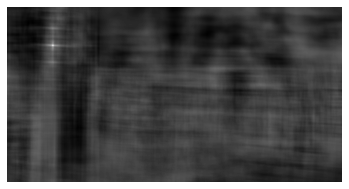

In [4]:
queens_tower = cv.imread("./scene.png", 0)
larger_tower_template = cv.imread("./template.png", 0)

correlation = normalised_cross_correlation(queens_tower, larger_tower_template)
#correlation = cross_correlation(queens_tower, larger_tower_template)

plot.imshow(correlation, cmap="gray")

plot.axis("off")
plot.show()

#### Correlation of smaller template

libpng warning: sBIT: invalid


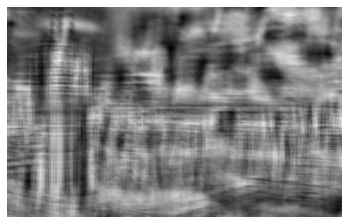

In [5]:
smaller_tower_template = cv.imread("./template_small.png", 0)

correlation = normalised_cross_correlation(queens_tower, smaller_tower_template)
#correlation = cross_correlation(queens_tower, smaller_tower_template)

plot.imshow(correlation, cmap="gray")

plot.axis("off")
plot.show()

Normalised Cross-correlation is not scale invariant. Because the small template is at a different scale to the scene, it never correlates well at any point. Therefore, it is limited in real-world applications since it's very unlikely that a template will be at the same size (pixel-wise) as its scene.

### Question 2: Co-occurance Matrices

#### Co-occurance Functions

In [6]:
def symmetrise(matrix):
    return matrix + matrix.T - np.diag(np.diag(matrix))

def co_occurance_matrix(image, angle, spacing):
    dx = round(spacing * np.cos(np.pi * angle / 180))
    dy = round(spacing * np.sin(np.pi * angle / 180))

    max_value = np.max(image)
    min_value = np.min(image)
    height, width = image.shape

    matrix = np.zeros((
        max_value + 1 - min_value,
        max_value + 1 - min_value
    ))

    for i in range(height - dy):
        for j in range(width - dx):
            a, b = image[i, j], image[i + dy, j + dx]
            matrix[a - min_value, b - min_value] += 1

    return symmetrise(matrix)

def calculate_co_occurances(image, angles=(0, 45, 90), spaces=(1, 2)):
    matrices = []

    for angle in angles:
        for space in spaces:
            matrices.append(co_occurance_matrix(image, angle, space))

    return np.array(matrices)


#### Find the Co-occurance matrices for the two images

In [7]:
image_a = np.array([
    [1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0],
    [1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0],
    [1, 0, 1, 0, 1]
])

image_b = np.array([
    [1, 0, 0, 1, 1],
    [1, 1, 0, 0, 1],
    [0, 1, 1, 0, 0],
    [0, 0, 1, 1, 0],
    [1, 0, 0, 1, 1]
])

image_a_co_occurrances = calculate_co_occurances(image_a)
image_b_co_occurrances = calculate_co_occurances(image_b)

#### Find the characteristic vectors of each matrix

In [8]:
def energy_characteristic(matrix):
    return np.sum([v ** 2 for row in matrix for v in row])

def entropy_characteristic(matrix):
    return np.sum([(-v * np.log(v) if v > 0 else 0) for row in matrix for v in row])

def maximum_characteristic(matrix):
    return np.max(matrix)

def contrast_characteristic(matrix):
    return np.sum([((a - b) ** 2 * v) for (a, row) in enumerate(matrix) for (b, v) in enumerate(row)])

def homogenity_characteristic(matrix):
    return np.sum([(v / (1 + abs(a - b))) for (a, row) in enumerate(matrix) for (b, v) in enumerate(row)])

def get_characteristics(matrices):
    energy_vector = []
    entropy_vector = []
    maximum_vector = []

    for matrix in matrices:
        normalised_matrix = matrix / matrix.sum()
        
        energy_vector.append(energy_characteristic(normalised_matrix))
        entropy_vector.append(entropy_characteristic(normalised_matrix))
        maximum_vector.append(maximum_characteristic(normalised_matrix))

    return energy_vector, entropy_vector, maximum_vector

print(*get_characteristics(image_a_co_occurrances), sep="\n")
print(*get_characteristics(image_b_co_occurrances), sep="\n")


[0.5, 0.5022222222222222, 0.5, 0.5, 0.5, 0.5022222222222222]
[0.6931471805599453, 0.6909233093138181, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6909233093138181]
[0.5, 0.5333333333333333, 0.5, 0.5, 0.5, 0.5333333333333333]
[0.2777777777777778, 0.5, 0.5, 0.5, 0.2777777777777778, 0.5]
[1.3296613488547582, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 1.3296613488547582, 0.6931471805599453]
[0.3333333333333333, 0.5, 0.5, 0.5, 0.3333333333333333, 0.5]
